In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import functools
from functools import partial
import scipy.integrate as integrate
import plotly
import plotly.graph_objs as go
import sympy as sp
from sympy.plotting import plot_parametric
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import multiprocessing as mp

plotly.offline.init_notebook_mode()

# Get $F_{X+Y}$ without using $D_1$ Operator
## Objective 
To get Get $F_{X+Y}$ without using $D_1$ Operator. 

We will construct the alternative way of getting $F_{X+Y}$ and test it against the numerical result. 

## Setup

Let $Z = X+Y$. The density function of $z$ is $f_Z(z) = \int^{\infty}_{-\infty} f_{X,Y}(x,z-x) dx$. 

We know the copula density $c_{X,Y}(u_1, u_2) = \frac{f_{X,Y}(F^{-1}_X(u_1), F^{-1}_Y(u_2))}{f_X(F^{-1}_X(u_1))f_Y(F^{-1}_Y(u_2))}$, so we can write

$$f_Z(z) = \int^{\infty}_{-\infty}c_{X,Y}(F_X(x), F_Y(z-x))f_X(x)f_Y(z-x)dx$$

Let $u_1 = F_X(x)$, so $du_1=f_X(x)dx$, and we rewrite 

$$f_Z(z) = \int^{1}_{0}c_{X,Y}\{u_1, F_Y[z-F^{-1}_X(u_1)]\}f_Y[z-F^{-1}_X(u_1)]du_1$$

## We start with Clayton
### Copula Density of Clayton

$$c(u,v)= (1+\theta)(uv)^{(-1-\theta)}(-1+u^{-\theta}+v^{-\theta})^{(-2-\frac{1}{\theta})}$$ 

### Remark: Limit of the integrand
Take Clayton copula as an example, the intergrand $I(u_1):=c_{X,Y}\{u_1, F_Y[z-F^{-1}_X(u_1)]\}f_Y[z-F^{-1}_X(u_1)]$ is undefined (in this case $\infty \cdot 0$) when $u_1=0$. 

On the other hand by definition, copula function are grounded, i.e. $C(0,v) = C(u,0)=0$, so $\frac{\partial^2 C(0,v)}{\partial u \partial v} =  \frac{\partial^2 C(u,0)}{\partial u \partial v}=c(0,v)=c(u,0)=0$.

As a consequence of definition of copula, $\lim_{u_1 \rightarrow 0 }I(u_1)=0$.

Clayton's Theta and Kendall's Tau: $\tau = \frac{\theta}{2-\theta}$

In [17]:
# def copula_density_Clayton(u, v, theta):
#     if u < 0.0000000001 or v < 0.0000000001 or u*v < 0.0000000001:
#         return 0
#     else:
#         A = (1+theta)
#         B = (u*v)**(-1-theta)
#         C = (-1+(u**-theta)+(v**-theta))**(-2-(1/theta))
#         return A*B*C

# def intergrand(u_1, z, Law_X, Law_Y, theta):
#     d = z-Law_X.ppf(u_1)
#     return copula_density_Clayton(u_1, Law_Y.cdf(d), theta)*Law_Y.pdf(d)

# def f_Z(z, Law_X, Law_Y, theta):
#     to_intergrate = partial(intergrand, z=z, Law_X = Law_RS, Law_Y = Law_RF, theta = theta)
#     I = integrate.simps(to_intergrate, 0, 1)
#     return I[0]

def copula_density_Clayton(u, v, theta):
    A = (1+theta)
    B = (u*v)**(-1-theta)
    C = (-1+(u**-theta)+(v**-theta))**(-2-(1/theta))
    return np.nan_to_num(A*B*C)

def f_Z(z, Law_X, Law_Y, theta):
    N     = 1000000
    u_1   = np.linspace(0,1,N) # Space of u_1
    d     = z-Law_X.ppf(u_1)
    m     = copula_density_Clayton(u_1, Law_Y.cdf(d), theta)*Law_Y.pdf(d)
    return np.nansum(((m[1:]+m[:-1])*1/N)/2) # Trapezoidal Rule 

### Generate Samples
We follow the steps by Nelsen (Section 2.9), for Clayton
1. Generate two independent uniform $(0,1)$ variates $u_1$ and $v_2$
2. Set $u_2 = [u_1^{-\theta}v_2^{(-\theta/(1+\theta)-1)}+1]^{-1/\theta}$


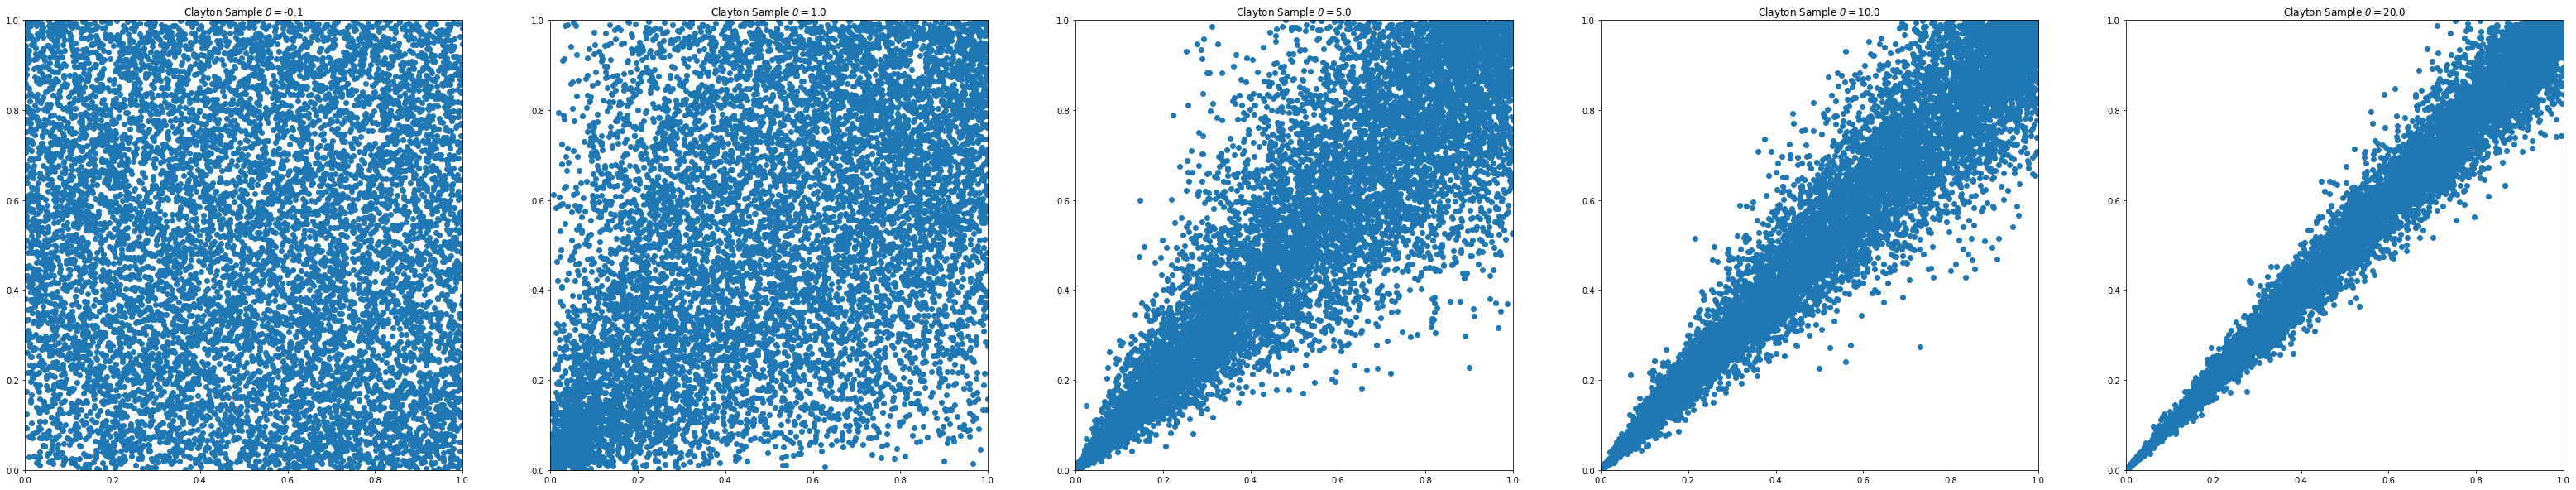

In [18]:
fig = plt.figure(figsize=(55,10))

theta_arr = [-0.1, 1,5,10, 20]
for i in range(1,6):
    fig.add_subplot(1,5,i)
    n = 10000
    theta = theta_arr[i-1]
    u1 = stats.uniform().rvs(n)
    v2 = stats.uniform().rvs(n)
    u2 = (u1**(-theta)*(v2**(-theta/(1+theta))-1)+1)**(-1/theta)
    plt.scatter(u1, u2)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title(r"Clayton Sample $\theta=$%.1f"%theta)

(-20, 20)

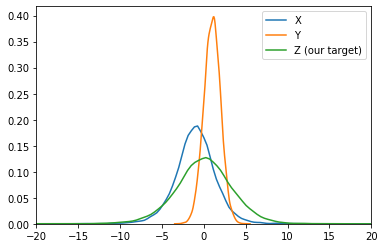

In [19]:
Law_X = stats.t(loc = -1, scale=2, df=6)
Law_Y = stats.norm(loc =  1, scale=1)
X = Law_X.ppf(u1)
Y = Law_Y.ppf(u2)
Z = X+Y
Z = np.sort(Z)
sns.kdeplot(X, label='X')
sns.kdeplot(Y, label='Y')
sns.kdeplot(Z, label='Z (our target)')
plt.xlim((-20,20))

In [20]:
n_1 = 200
result = np.zeros(n_1)

S = np.linspace(-25,25,n_1)
for i,z in enumerate(S):
    result[i] = f_Z(z, Law_X, Law_Y, theta)
    if i%20 == 0:
        print(i)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

divide by zero encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

overflow encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

divide by zero encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

overflow encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in multiply



0


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

overflow encountered in multiply



KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(S, result,      label='Z by copula', marker='.')
sns.kdeplot(Z,label='Z (our target)', marker='.')

In [ ]:
plt.figure(figsize=(16,8))

plt.plot(S, result,      label='Z', marker='.')
sns.kdeplot(Z,label='Z (our target)',marker='.')

plt.xlim((-15,-12))
plt.ylim((0.0002,0.0009))

In [ ]:
plt.figure(figsize=(16,8))

plt.plot(S, result,      label='Z', marker='.')
sns.kdeplot(Z,label='Z (our target)',marker='.')
plt.xlim((-12,-10))
plt.ylim((0.0008, 0.0025))

In [ ]:
plt.figure(figsize=(16,8))

plt.plot(S, result,      label='Z', marker='.')
sns.kdeplot(Z,label='Z (our target)',marker='.')

plt.xlim((-1,1))
plt.ylim((0.119,0.13))

In [ ]:
plt.figure(figsize=(16,8))

plt.plot(S, result,      label='Z', marker='.')
sns.kdeplot(Z,label='Z (our target)',marker='.')
plt.xlim((10,12))
plt.ylim((0.0005, 0.0018))

## Conclusion
1. The alternative "works" in the case $Z=X+Y$. 
2. The shape of the p.d.f. generated by the alternative method is sensible and close to the empirical p.d.f. generated by sns.kde. 
3. However if we take a closer look, we can see the "small" difference between the two results.  

# Get $F_{R^h}$ without using $D_1$ Operator
## Objective 
To get Get $F_{R^h}$ without using $D_1$ Operator. 

## Setting
$$R^H = n_S R^S + n_F R^F$$
Notice: We take a plus sign here, so $n_F <0$ means having a short position of the future in our portfolio. 
## Copula Density Transformation
We start with transforming random variable.
Let $\vec{X} = (X_1, ..., X_n)$ with density $f_{\vec{X}}(x_1,...,x_n)$, and an diffeomorphism transformation $\vec{g}: \mathbb{R}^n \rightarrow \mathbb{R}^n$. 

For the density of $f_{\vec{Y}}$ of $\vec{Y} = \vec{g}(\vec{X})$, we have
$$f_{\vec{Y}}(\vec{y}) = f_{\vec{X}}(\vec{g}^{-1}(\vec{y}))\left|\frac{\partial (x_1,..., x_n)}{\partial (y_1,..., y_n)} \right|$$

where $\left|\frac{\partial (x_1,..., x_n)}{\partial (y_1,..., y_n)} \right|$ is the Jacobian determinant of $g^{-1}$.

Example: If $\vec{Y} = A\vec{X}^\intercal + \vec{b}$, then 
$$
f_{\vec{Y}}(\vec{y}) = f_{\vec{X}}(A^{-1}(\vec{y}-\vec{b}))|\det A^{-1}|
$$



An famous example of the transformation of multivariate density is the Box-Mueller procedure:

\begin{align}
y_1 &= \sqrt{-2 \ln x_1} \cos 2\pi x_2\\
y_2 &= \sqrt{-2 \ln x_1} \sin 2\pi x_2\\ \text{so,}\\
x_1 &= e^{\frac{1}{2}(y_1^2 + y_2^2)}\\
x_2 &= \frac{1}{2 \pi} \arctan \frac{y_2}{y_1}\\
p_{\vec{Y}}(\vec{y}) &= 
\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}y_1^2}
\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}y_2^2}
p_{\vec{X}}(\vec{x})
\end{align}
Both $y_1$ and $y_2$ are Gaussian distributed with $\sigma=1$, if $x_1$ and $x_2$ are uniformly distributd in $[0,1]$. ($p_{\vec{X}}(\vec{x})=1$ because density of bivariate uniform distribution with support $[0,1]^2$ is always $1$).
## Our case
Our hedging equation can be written in matrix form.
$$
R^H = \begin{bmatrix}n_S & n_F\end{bmatrix}
\begin{bmatrix}R^S \\ R^F\end{bmatrix}.
$$

With the density transformation, one can easily write $f_{\vec{X}}$ in terms of copula density by using 
$c_{\vec{X}}(\vec{u}) = \frac{f_{\vec{X}}(F^{-1}_{X_1}(u_1),..., (F^{-1}_{X_n}(u_n))}{f_{X_1}(F^{-1}_{X_1}(u_1))...f_{X_n}(F^{-1}_{X_n}(u_n))}$. All we need is the inverse of the transformation $\begin{bmatrix}n_S & n_F\end{bmatrix}$ and its Jacobian determinant. 


However, the transformation in matrix form is not invertible due to its shape (Difficult to get an inverse of a 2x1 matrix). We introduce a helper coordinate to help us retrieve the inverse of transformation. 

$$
\begin{bmatrix}R^H\\R^F\end{bmatrix} = \begin{bmatrix}n_S & n_F\\0&1\end{bmatrix}
\begin{bmatrix}R^S \\ R^F\end{bmatrix}=A\begin{bmatrix}R^S \\ R^F\end{bmatrix}.
$$

Now we can write
$$
f_{R^H, R^F}(y_1, y_2) = 
f_{R^S, R^F}\bigg(
A^{-1}
\begin{pmatrix} y_1 \\ y_2 \end{pmatrix} \bigg)
|\det A^{-1}|,
$$
and we can integrate out $y_2$ to get
$$
f_{R^H}(y_1) = \int_{\mathbb{R}} 
f_{R^S, R^F}\bigg(
A^{-1}
\begin{pmatrix} y_1 \\ y_2 \end{pmatrix} \bigg)
|\det A^{-1}|dy_2.
$$

Skipping all intermediate steps (I need time to complie them...), we have

$$\begin{align}
f_{R^H}(y_1) = \left|\frac{1}{n_S}\right|
\int_0^1
c_{R^S, R^F}
\left(F_{R^S}\left(\frac{y_1 - n_F F^{-1}_{R^F}(u_2)}{n_S}\right), u_2\right)
f_{R^S}\left(\frac{y_1 - n_F F^{-1}_{R^F}(u_2)}{n_S}\right)du_2
\end{align}$$

reference: (I know... I need a better reference)
https://en.wikibooks.org/wiki/Probability/Transformation_of_Probability_Densities#Mapping_of_a_Random_Vector_to_a_Random_Variable_(n%3E1,_m=1)

Mathematics for Economists should be a good reference.

## Solving the integral
There are many scheme to approximate a definite integral. 

### Rectangle Rule
$$I_R = f(a)(b-a)$$

### Midpoint Rule
$$I_M = f\left(\frac{(a+b)}{2}\right)(b-a)$$

### Trapezoid Rule (I used this for p.d.f. and c.d.f. estimation)
$$I_T = (f(a) + f(b))\frac{b-a}{2}$$

### Simpson's Rule
$$I_S = \left( f(a) + f\left(\frac{a+b}{2}\right)+f(b)\right)\frac{b-a}{6}$$

### Error Analysis of Trapezoid Rule
$$ E_T = -\frac{f''(c)}{12}(b-a)^3$$

An asymptotic error estimate for $N \rightarrow \infty$ is given by 
$$E_T = -\frac{(b-a)^2}{12N^2}[f'(b) - f'(a)]+O(N^{-3})$$

(-20, 20)

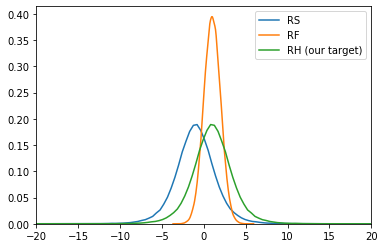

In [21]:
nS = -1
nF = 0.001

n = 100000
theta = 10
u1 = stats.uniform().rvs(n)
v2 = stats.uniform().rvs(n)
u2 = (u1**(-theta)*(v2**(-theta/(1+theta))-1)+1)**(-1/theta)

Law_RS = stats.t(loc = -1, scale=2, df=6)
Law_RF = stats.norm(loc =  1, scale=1)
RS = Law_X.ppf(u1)
RF = Law_Y.ppf(u2)
RH = nS*RS + nF*RF

RH = np.sort(RH)
sns.kdeplot(RS, label='RS')
sns.kdeplot(RF, label='RF')
sns.kdeplot(RH, label='RH (our target)')
plt.xlim((-20,20))

In [22]:
def f_Z_2(y1, nS, nF, Law_RS, Law_RF, theta):
    N = 100000
    u2 = np.linspace(0,1,N)
    a = (y1-nF*Law_RF.ppf(u2))/nS
    A = copula_density_Clayton(Law_RS.cdf(a), u2, theta)
    B = Law_RS.pdf(a)
#     C = Law_RF.pdf(Law_RF.ppf(u2))
#     D = 1/Law_RF.pdf(Law_RF.ppf(u2))
    m = A*B#*C*D§
    return np.nansum(((m[1:]+m[:-1])*1/N)/2)/np.abs(nS)

In [ ]:
n_1 = 10000
result = np.zeros(n_1)
rang = 50
S = np.linspace(-rang/2,rang/2,n_1)
for i,y1 in enumerate(S):
    result[i] = f_Z_2(y1, nS, nF, Law_RS, Law_RF, theta)
    if i%20 == 0:
        print(i)

In [ ]:
rang/n_1 # integrator is not so small...

In [ ]:
plt.figure(figsize=(16,8))
# sns.kdeplot(RS, label='RS')
# sns.kdeplot(RF, label='RF')
plt.plot(S, result,      label='RH by copula', marker='.')
sns.kdeplot(RH,label='RH by numerical', marker='.')

In [ ]:
plt.figure(figsize=(16,8))
# plt.plot(S[1:], Law_RS.cdf(S[1:]), label='RS')
# plt.plot(S[1:], Law_RF.cdf(S[1:]), label='RF')
plt.plot(S[1:],np.cumsum(0.5*((result[1:]+ result[:-1])*rang/n_1)), label='RH by copula')
plt.legend()

In [ ]:
ecdf = ECDF(RH)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(S[1:], ecdf(S[1:]), label='RH by numerical')
plt.plot(S[1:],np.cumsum(0.5*((result[1:]+ result[:-1])*rang/n_1)), label='RH by copula', marker='.')
plt.legend()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(S[1:], ecdf(S[1:]), label='RH by numerical')
plt.plot(S[1:],np.cumsum(0.5*((result[1:]+ result[:-1])*rang/n_1)), label='RH by copula', marker='.')
plt.legend()

plt.xlim((10,10.25))
plt.ylim((.9978, 0.9982))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(S[1:], ecdf(S[1:]), label='RH by numerical')
plt.plot(S[1:],np.cumsum(0.5*((result[1:]+ result[:-1])*rang/n_1)), label='RH by copula', marker='.')
plt.legend()

plt.xlim((-1.9,-1.6))
plt.ylim((.098, 0.118))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(S[1:], ecdf(S[1:]), label='RH by numerical')
plt.plot(S[1:],np.cumsum(0.5*((result[1:]+ result[:-1])*rang/n_1)), label='RH by copula', marker='.')
plt.legend()

plt.xlim((-14,-13.9))
plt.ylim((0.000138, 0.000153))

## Our Contribution
It is worth to discuss our approach's advantage. 

Patton (2013) in Ch. 16 of Handook of Economic Forecast reported that the closed form of marginal distribution linear combination of variables modelled by copula is NOT known, and to obtain VaR and ES of a portfolio of variables modelled in such way is via SIMULATION. 

"draft"


Our approach does not require simulation. This brings the advantage of speed and accuracy (Well... we need evidence about that). The convergence rate of an empirical c.d.f. is $\sqrt{n}$ ($n$ is number of sample generated). Our approach does not subject to this kind of convergence, but subject to numerical integration. For trapezoid rule, the error is bounded to $O(N^3)$ where $N$ is the number of partition in $[0,1]$. 

Patton also suggested for the values of $q$ closer to zero or one (I don't know why..., is this related to the extreme value theory?), the sample size $n$ needs to be higher. Our approach is not subject to this constrain. 


As per Dvoretzky-Kiefer-Wolfowitz inequality the interval that contains the true CDF with probability $1-\delta$ is specified as

$$F_n(x)-\epsilon \leq F(x)\leq F_n(x)+\epsilon$$
where $$\epsilon = \sqrt{\frac{\ln \frac{2}{\delta}}{2n}}$$

On the other hand, our approach provides a strict bound of error. 

# Optimisation for speed

In [23]:
def f_Z_2(y1, nS, nF, Law_RS, Law_RF, theta):
    N = 100000
    u2 = np.linspace(0,1,N)
    a = (y1-nF*Law_RF.ppf(u2))/nS
    A = copula_density_Clayton(Law_RS.cdf(a), u2, theta)
    B = Law_RS.pdf(a)
#     C = Law_RF.pdf(Law_RF.ppf(u2))
#     D = 1/Law_RF.pdf(Law_RF.ppf(u2))
    m = A*B#*C*D
    return np.sum(((m[1:]+m[:-1])*1/N)/2)/np.abs(nS)

In [24]:
# sloppy optimization
fn = partial(f_Z_2, nS=nS, nF=nF, Law_RS= Law_RS, Law_RF=Law_RF, theta=theta)
v_fn = np.vectorize(fn)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

divide by zero encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

divide by zero encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in multiply



CPU times: user 42.3 s, sys: 564 ms, total: 42.8 s
Wall time: 43 s


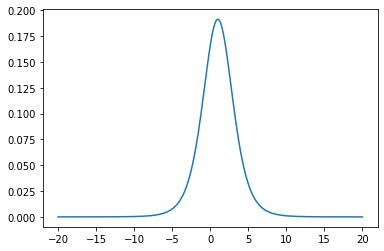

In [25]:
%%time
ny = 1000
y1 = np.linspace(-20,20,ny)
results = v_fn(y1)
plt.plot(y1, results)

In [61]:
def f_Z_3(y1, nS, nF, Law_RS, Law_RF, theta):
    ny = len(y1)
    N = 100000
    u2 = np.linspace(0,1,N)
    rf_ppf = np.array([Law_RF.ppf(u2)]*ny)
    u2m = np.array([u2]*ny)
    a = (np.repeat(y1.reshape(ny,1), N, axis=1) - nF*rf_ppf)/nS
    A = copula_density_Clayton(Law_RS.cdf(a), u2m, theta)
    B = Law_RS.pdf(a)
    m = A*B
    return np.sum((((m[:,1:]+m[:,:-1])/N)/2)/np.abs(nS), axis=1)

In [62]:
%%time
ny = 1000
y1 = np.linspace(-20,20,ny)
result = f_Z_3(y1, nS, nF, Law_RS, Law_RF, theta)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

divide by zero encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

divide by zero encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in multiply



CPU times: user 43.3 s, sys: 13.1 s, total: 56.4 s
Wall time: 57.2 s


In [20]:
%%time
ny = len(y1)
N = 100000
u2 = np.linspace(0,1,N)

CPU times: user 477 µs, sys: 4.74 ms, total: 5.22 ms
Wall time: 4.82 ms


In [21]:
%%time
rf_ppf = np.array([Law_RF.ppf(u2)]*ny)

CPU times: user 192 ms, sys: 154 ms, total: 345 ms
Wall time: 345 ms


In [23]:
%%time
u2m = np.array([u2]*ny)

CPU times: user 193 ms, sys: 196 ms, total: 389 ms
Wall time: 388 ms


In [24]:
%%time
a = (np.repeat(y1.reshape(ny,1), N, axis=1) - nF*rf_ppf)/nS

CPU times: user 783 ms, sys: 368 ms, total: 1.15 s
Wall time: 1.15 s


In [28]:
%%time
u1 = Law_RS.cdf(a)

CPU times: user 18.7 s, sys: 3.03 s, total: 21.8 s
Wall time: 22.5 s


In [29]:
%%time
A = copula_density_Clayton(u1, u2m, theta)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

divide by zero encountered in power

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

divide by zero encountered in power



CPU times: user 8.1 s, sys: 1.86 s, total: 9.96 s
Wall time: 9.97 s


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in multiply



In [26]:
%%time
B = Law_RS.pdf(a)

CPU times: user 12.4 s, sys: 7.33 s, total: 19.7 s
Wall time: 20.3 s


In [27]:
%%time
m = A*B

CPU times: user 340 ms, sys: 636 ms, total: 976 ms
Wall time: 976 ms


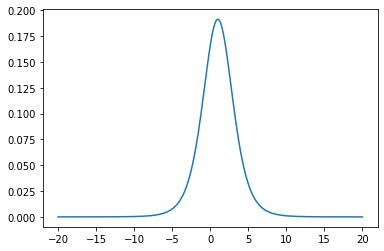

In [113]:
plt.plot(y1, result)

In [116]:
Law_RS.mean()

-1.0

In [122]:
import tensorflow_probability as tfp 


In [123]:
Law_RS = stats.t(loc=-1, scale=2, df=6)
Law_RS_tfp = tfp.distributions.StudentT(loc=-1, scale=2, df=6)

In [125]:
Law_RS.cdf(u2) - Law_RS_tfp.cdf(u2)

<tf.Tensor: shape=(100000,), dtype=float32, numpy=
array([-5.9604645e-08,  0.0000000e+00,  0.0000000e+00, ...,
       -5.9604645e-08, -5.9604645e-08, -1.1920929e-07], dtype=float32)>

In [128]:
Law_RS.pdf(u2) - Law_RS_tfp.prob(u2)

<tf.Tensor: shape=(100000,), dtype=float32, numpy=
array([-2.9802322e-08, -1.4901161e-08, -1.4901161e-08, ...,
       -2.9802322e-08, -2.2351742e-08,  0.0000000e+00], dtype=float32)>

In [131]:
argument = {'loc':-1, 'scale':2, 'df':6}

In [139]:
%%time
tfp.distributions.StudentT(**argument).cdf(a)

CPU times: user 30.7 s, sys: 5.08 s, total: 35.8 s
Wall time: 3.9 s


<tf.Tensor: shape=(1000, 100000), dtype=float32, numpy=
array([[0.0000000e+00, 9.9997807e-01, 9.9997807e-01, ..., 9.9997813e-01,
        9.9997813e-01, 1.0000000e+00],
       [0.0000000e+00, 9.9997783e-01, 9.9997783e-01, ..., 9.9997789e-01,
        9.9997789e-01, 1.0000000e+00],
       [0.0000000e+00, 9.9997759e-01, 9.9997759e-01, ..., 9.9997765e-01,
        9.9997765e-01, 1.0000000e+00],
       ...,
       [0.0000000e+00, 3.9670889e-05, 3.9672781e-05, ..., 3.9770515e-05,
        3.9772374e-05, 1.0000000e+00],
       [0.0000000e+00, 3.9198276e-05, 3.9200146e-05, ..., 3.9296530e-05,
        3.9298404e-05, 1.0000000e+00],
       [0.0000000e+00, 3.8732109e-05, 3.8733957e-05, ..., 3.8829006e-05,
        3.8830858e-05, 1.0000000e+00]], dtype=float32)>

In [166]:
tpar = tfp.distributions.StudentT(**argument).parameters
# stats.t(**tpar)
tpar['df', 'loc']

KeyError: ('df', 'loc')

In [176]:
tpar.get('loc')

In [156]:
tfp.distributions.Normal(loc=1,scale=2)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.5631032, -1.5631032], dtype=float32)>

In [151]:
tdf = tfp.distributions.StudentT(**argument).df
tloc = tfp.distributions.StudentT(**argument).loc
tscale = tfp.distributions.StudentT(**argument).scale

In [138]:
%%time
stats.t(**argument).cdf(a)

CPU times: user 19.5 s, sys: 3.17 s, total: 22.6 s
Wall time: 23.3 s


array([[0.00000000e+00, 9.99978068e-01, 9.99978069e-01, ...,
        9.99978118e-01, 9.99978119e-01, 1.00000000e+00],
       [0.00000000e+00, 9.99977827e-01, 9.99977828e-01, ...,
        9.99977878e-01, 9.99977879e-01, 1.00000000e+00],
       [0.00000000e+00, 9.99977583e-01, 9.99977584e-01, ...,
        9.99977634e-01, 9.99977635e-01, 1.00000000e+00],
       ...,
       [0.00000000e+00, 3.96709022e-05, 3.96727733e-05, ...,
        3.97705611e-05, 3.97724376e-05, 1.00000000e+00],
       [0.00000000e+00, 3.91982704e-05, 3.92001157e-05, ...,
        3.92965565e-05, 3.92984071e-05, 1.00000000e+00],
       [0.00000000e+00, 3.87321419e-05, 3.87339619e-05, ...,
        3.88290766e-05, 3.88309018e-05, 1.00000000e+00]])

In [197]:
def f_Z_4(y1, nS, nF, Law_RS, Law_RF, theta):
    # Tensorflow Probability Version
    ny = len(y1)
    N = 100000
    u2 = np.linspace(0,1,N)
    
    try:
        q = Law_RF.quantile(u2)
        rf_ppf = np.array([np.array(q)]*ny)
    except:
        tpar = Law_RF.parameters
        Law_RF_scipy = stats.t(loc=tpar.get('loc'), scale=tpar.get('scale'),df=tpar.get('df'))
        rf_ppf = np.array([Law_RF_scipy.ppf(u2)]*ny)
    
    u2m = np.array([u2]*ny)
    a = (np.repeat(y1.reshape(ny,1), N, axis=1) - nF*rf_ppf)/nS
    A = copula_density_Clayton(Law_RS.cdf(a), u2m, theta)
    B = Law_RS.prob(a)
    m = A*B
    return np.nansum((((m[:,1:]+m[:,:-1])/N)/2)/np.abs(nS), axis=1)

In [185]:
Law_RS_scipy = stats.t(loc = -1, scale=2, df=6)
Law_RF_scipy = stats.norm(loc =  1, scale=1)

Law_RS = tfp.distributions.StudentT(loc = -1, scale=2, df=6)
Law_RF = tfp.distributions.Normal(  loc =  1, scale=1)

In [199]:
%%time
ny = 1000
y1 = np.linspace(-20,20,ny)
result = f_Z_4(y1, nS, nF, Law_RS, Law_RF, theta)

CPU times: user 46.9 s, sys: 17.5 s, total: 1min 4s
Wall time: 14.8 s


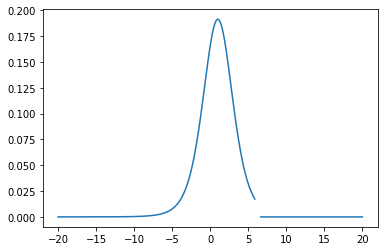

In [201]:
plt.plot(y1, result)

In [182]:
Law_RS.cdf(a) * Law_RS.prob(a)

<tf.Tensor: shape=(1000, 100000), dtype=float32, numpy=
array([[0.0000000e+00, 5.9835361e-06, 5.9832450e-06, ..., 5.9677282e-06,
        5.9674326e-06, 0.0000000e+00],
       [0.0000000e+00, 6.0598318e-06, 6.0595371e-06, ..., 6.0437987e-06,
        6.0434936e-06, 0.0000000e+00],
       [0.0000000e+00, 6.1372407e-06, 6.1369306e-06, ..., 6.1209621e-06,
        6.1206524e-06, 0.0000000e+00],
       ...,
       [0.0000000e+00, 4.7152976e-10, 4.7157833e-10, ..., 4.7408860e-10,
        4.7413651e-10, 0.0000000e+00],
       [0.0000000e+00, 4.5949583e-10, 4.5954274e-10, ..., 4.6198415e-10,
        4.6203175e-10, 0.0000000e+00],
       [0.0000000e+00, 4.4778958e-10, 4.4783488e-10, ..., 4.5020979e-10,
        4.5025569e-10, 0.0000000e+00]], dtype=float32)>

In [183]:
Law_RF.quantile(u2)

<tf.Tensor: shape=(100000,), dtype=float32, numpy=
array([      -inf, -3.2648888, -3.1074777, ...,  5.107166 ,  5.264587 ,
              inf], dtype=float32)>

In [187]:
try:
    rf_ppf = np.array([Law_RF.quantile(u2)]*ny)
except:
    tpar = Law_RF.parameters
    Law_RF_scipy = stats.t(loc=tpar.get('loc'), scale=tpar.get('scale'),df=tpar.get('df'))
    rf_ppf = np.array([Law_RF_scipy.ppf(u2)]*ny)

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [189]:
q = Law_RF.quantile(u2)
rf_ppf = np.array([Law_RF.quantile(u2)]*ny)

In [190]:
rf_ppf = np.array([q]*ny)

KeyboardInterrupt: 

In [196]:
np.array([np.array(q)]*ny)

array([[      -inf, -3.2648888, -3.1074777, ...,  5.107166 ,  5.264587 ,
               inf],
       [      -inf, -3.2648888, -3.1074777, ...,  5.107166 ,  5.264587 ,
               inf],
       [      -inf, -3.2648888, -3.1074777, ...,  5.107166 ,  5.264587 ,
               inf],
       ...,
       [      -inf, -3.2648888, -3.1074777, ...,  5.107166 ,  5.264587 ,
               inf],
       [      -inf, -3.2648888, -3.1074777, ...,  5.107166 ,  5.264587 ,
               inf],
       [      -inf, -3.2648888, -3.1074777, ...,  5.107166 ,  5.264587 ,
               inf]], dtype=float32)

array([      -inf, -3.2648888, -3.1074777, ...,  5.107166 ,  5.264587 ,
              inf], dtype=float32)

In [43]:
np.pi

3.141592653589793

## Retrieve the spectral risk measure from PDF
The spectral risk measure we are considering is exponental risk meausre
$$
\text{ERM}(R^h) = -\int_0^1 \frac{ke^{-ks}}{1-e^{-k}}q_s(R^h)ds
$$

$k>0$ is the Arrow-Pratt coefficient of absolute risk aversion.

$q_s(R^h)$ is the $s^{th}$ quantile of $R^h$.

Quantile function is the inverse of CDF. We need to get the CDF from PDF.

In [56]:
pdf = pd.DataFrame({'x':y1, 'density':results}) 
pdf.loc[:,'dx'] = (pdf.x - pdf.x.shift(1))
pdf.head()

,x,density,dx
0,-20.00000,0.000006,NaN
1,-19.95996,0.000006,0.04004
2,-19.91992,0.000006,0.04004
3,-19.87988,0.000006,0.04004
4,-19.83984,0.000006,0.04004


In [64]:
cdf = np.cumsum(pdf.density[:-1]+ pdf.density[1:]) * pdf.dx[1:]/2
cdf = pd.DataFrame({'x':y1, 'prob':cdf}) 
cdf.loc[:,'d_prob'] = cdf.prob - cdf.prob.shift(1)
cdf.head()

,x,prob,d_prob
0,-20.00000,NaN,NaN
1,-19.95996,2.421766e-07,NaN
2,-19.91992,4.874458e-07,2.452692e-07
3,-19.87988,7.358524e-07,2.484066e-07
4,-19.83984,9.874421e-07,2.515897e-07


In [65]:
k = 1
cdf.loc[:,'intergrand'] = (k*np.exp(-k*cdf.prob)/(1-np.exp(-k)))*cdf.x

In [67]:
cdf.head()

,x,prob,d_prob,intergrand
0,-20.00000,NaN,NaN,NaN
1,-19.95996,2.421766e-07,NaN,-31.576184
2,-19.91992,4.874458e-07,2.452692e-07,-31.512834
3,-19.87988,7.358524e-07,2.484066e-07,-31.449484
4,-19.83984,9.874421e-07,2.515897e-07,-31.386134


In [73]:
np.nansum((cdf.intergrand[1:]+ cdf.intergrand[:-1])*cdf.d_prob/2)

0.34304137140099433

In [77]:
def exponential_risk_measure(k, x, density):
    # k: absolute risk aversion
    # x: variable
    # density: variable's corresponding density
    pdf = pd.DataFrame({'x':x, 'density':density}) 
    pdf.loc[:,'dx'] = (pdf.x - pdf.x.shift(1))
    
    cdf = np.cumsum(pdf.density[:-1]+ pdf.density[1:]) * pdf.dx[1:]/2
    cdf = pd.DataFrame({'x':y1, 'prob':cdf}) 
    cdf.loc[:,'d_prob'] = cdf.prob - cdf.prob.shift(1)
    cdf.loc[:,'intergrand'] = (k*np.exp(-k*cdf.prob)/(1-np.exp(-k)))*cdf.x
    return np.nansum((cdf.intergrand[1:]+ cdf.intergrand[:-1])*cdf.d_prob/2)

In [80]:
exponential_risk_measure(1 , y1, results)

0.34304137140099433